<a href="https://colab.research.google.com/github/narenmrkp/nn-LeafDetection-MLOPs/blob/main/Leaf_Disease_Classification_Computer_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from IPython.display import Image, display

import matplotlib.pyplot as plt
import tensorflow_hub as hub

import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [2]:
!nvidia-smi

Wed Dec 10 04:38:06 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
!wget https://storage.googleapis.com/ibeans/train.zip
!wget https://storage.googleapis.com/ibeans/validation.zip
!wget https://storage.googleapis.com/ibeans/test.zip

--2025-12-10 04:38:14--  https://storage.googleapis.com/ibeans/train.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.187.207, 64.233.188.207, 64.233.189.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.187.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 143812152 (137M) [application/zip]
Saving to: ‘train.zip’

train.zip           100%[===================>] 137.15M  20.0MB/s    in 8.3s    

2025-12-10 04:38:24 (16.5 MB/s) - ‘train.zip’ saved [143812152/143812152]

--2025-12-10 04:38:24--  https://storage.googleapis.com/ibeans/validation.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.187.207, 64.233.188.207, 64.233.189.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.187.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18504213 (18M) [application/zip]
Saving to: ‘validation.zip’

validation.zip      100%[===================

In [4]:
!mkdir beans

In [5]:
!unzip train.zip -d beans/
!unzip test.zip -d beans/
!unzip validation.zip -d beans/


Archive:  train.zip
   creating: beans/train/
   creating: beans/train/healthy/
   creating: beans/train/angular_leaf_spot/
   creating: beans/train/bean_rust/
  inflating: beans/train/healthy/healthy_train.265.jpg  
  inflating: beans/train/healthy/healthy_train.271.jpg  
  inflating: beans/train/healthy/healthy_train.259.jpg  
  inflating: beans/train/healthy/healthy_train.99.jpg  
  inflating: beans/train/healthy/healthy_train.311.jpg  
  inflating: beans/train/healthy/healthy_train.66.jpg  
  inflating: beans/train/healthy/healthy_train.72.jpg  
  inflating: beans/train/healthy/healthy_train.305.jpg  
  inflating: beans/train/healthy/healthy_train.339.jpg  
  inflating: beans/train/healthy/healthy_train.113.jpg  
  inflating: beans/train/healthy/healthy_train.107.jpg  
  inflating: beans/train/healthy/healthy_train.106.jpg  
  inflating: beans/train/healthy/healthy_train.112.jpg  
  inflating: beans/train/healthy/healthy_train.338.jpg  
  inflating: beans/train/healthy/healthy_trai

In [6]:
!ls beans

test  train  validation


In [7]:
!find beans -type f | wc -l

1296


In [8]:
!find beans/test -type f | wc -l

128


In [9]:
!find beans/validation -type f | wc -l

133


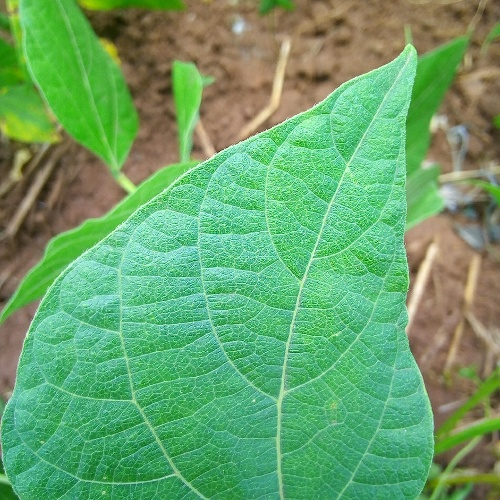

In [10]:
display(Image('beans/train/healthy/healthy_train.0.jpg'))

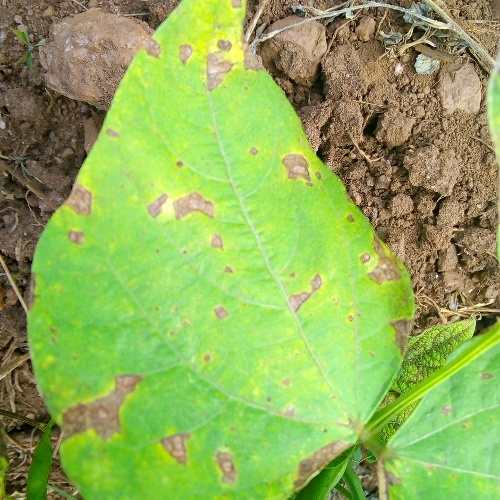

In [11]:
display(Image('beans/train/angular_leaf_spot/angular_leaf_spot_train.124.jpg'))

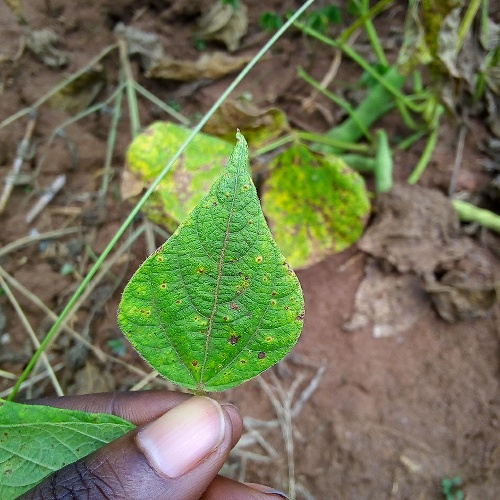

In [12]:
display(Image('beans/train/bean_rust/bean_rust_train.162.jpg'))

In [13]:
batch_size = 128
img_height = 224
img_width = 224

In [14]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory('beans/train',
  seed=111,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1034 files belonging to 3 classes.


In [15]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory('beans/test',
  seed=111,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 128 files belonging to 3 classes.


In [16]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory('beans/validation',
  seed=111,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 133 files belonging to 3 classes.


In [17]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(128, 224, 224, 3)
(128,)


In [18]:
classes=train_ds.class_names
print(classes)

['angular_leaf_spot', 'bean_rust', 'healthy']


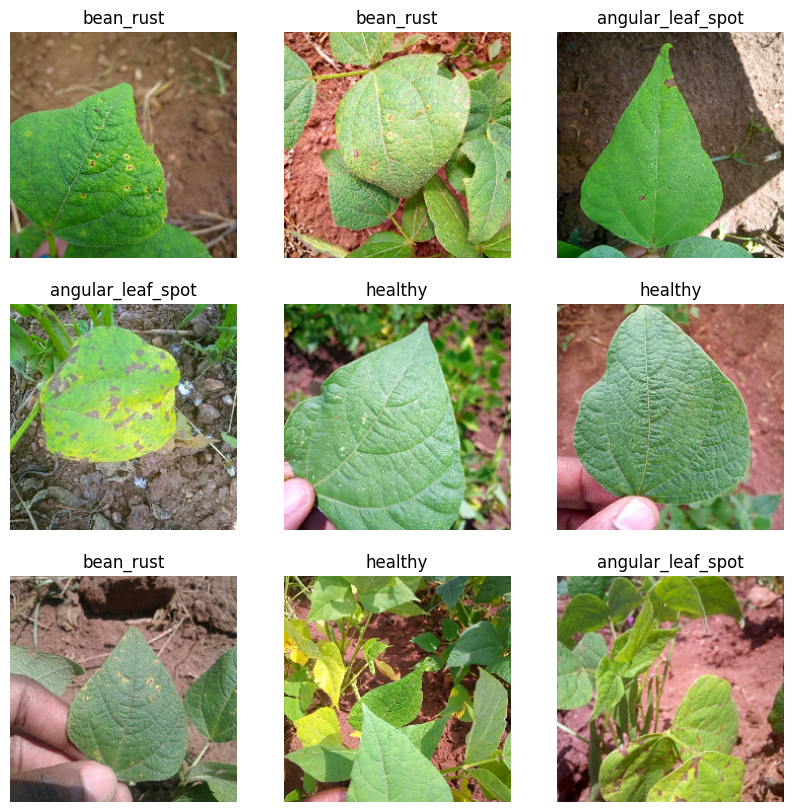

In [19]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(classes[labels[i]])
    plt.axis("off")

In [20]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [21]:
feature_extractor = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

In [22]:
feature_extractor_layer = hub.KerasLayer(feature_extractor, input_shape=(img_height,img_width,3))

In [23]:
feature_extractor_layer.trainable = False

In [25]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [26]:
tf.random.set_seed(111)

In [28]:
# model = tf.keras.Sequential([
#   normalization_layer,
#   feature_extractor_layer,
#   tf.keras.layers.Dropout(0.3),
#   tf.keras.layers.Dense(3,activation='softmax')
# ])
import tensorflow as tf

class HubWrapper(tf.keras.layers.Layer):
    def __init__(self, hub_layer, **kwargs):
        super().__init__(**kwargs)
        self.hub_layer = hub_layer

    def call(self, inputs):
        return self.hub_layer(inputs)

# usage
wrapped = HubWrapper(feature_extractor_layer)
model = tf.keras.Sequential([
    normalization_layer,
    wrapped,
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(3, activation='softmax')
])


In [29]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [30]:
history = model.fit(train_ds, epochs=20, validation_data=val_ds)

Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 47s 3s/step - accuracy: 0.3725 - loss: 1.2474 - val_accuracy: 0.7068 - val_loss: 0.7706
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.6291 - loss: 0.8435 - val_accuracy: 0.7594 - val_loss: 0.6002
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.7148 - loss: 0.6655 - val_accuracy: 0.7895 - val_loss: 0.5275
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.7719 - loss: 0.5740 - val_accuracy: 0.7970 - val_loss: 0.4693
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.7857 - loss: 0.5148 - val_accuracy: 0.8271 - val_loss: 0.4311
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.8064 - loss: 0.4601 - val_accuracy: 0.8496 - val_loss: 0.4023
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.8375 - loss: 0.4195 - val_accuracy: 0.8421 - val_loss: 0.3769
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.8441 - loss: 0.4026 - val_accuracy: 0.8797 - val_loss: 0.3634
E

In [31]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hub_wrapper (HubWrapper)        │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         3,843 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,531 (45.05 KB)

 Trainable params: 3,843 (15.01 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,688 (30.04 KB)

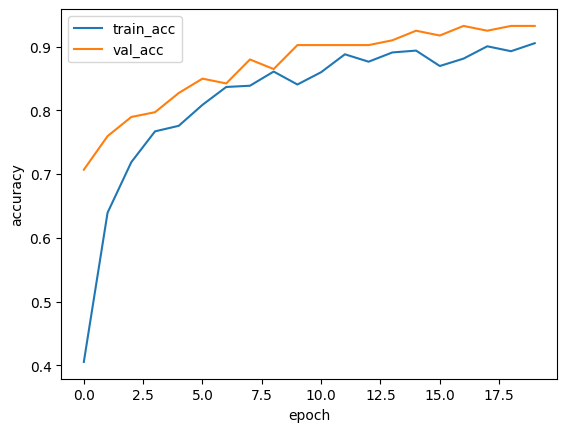

In [32]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='best')
plt.show()

In [33]:
result=model.evaluate(test_ds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.8984 - loss: 0.2515


1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


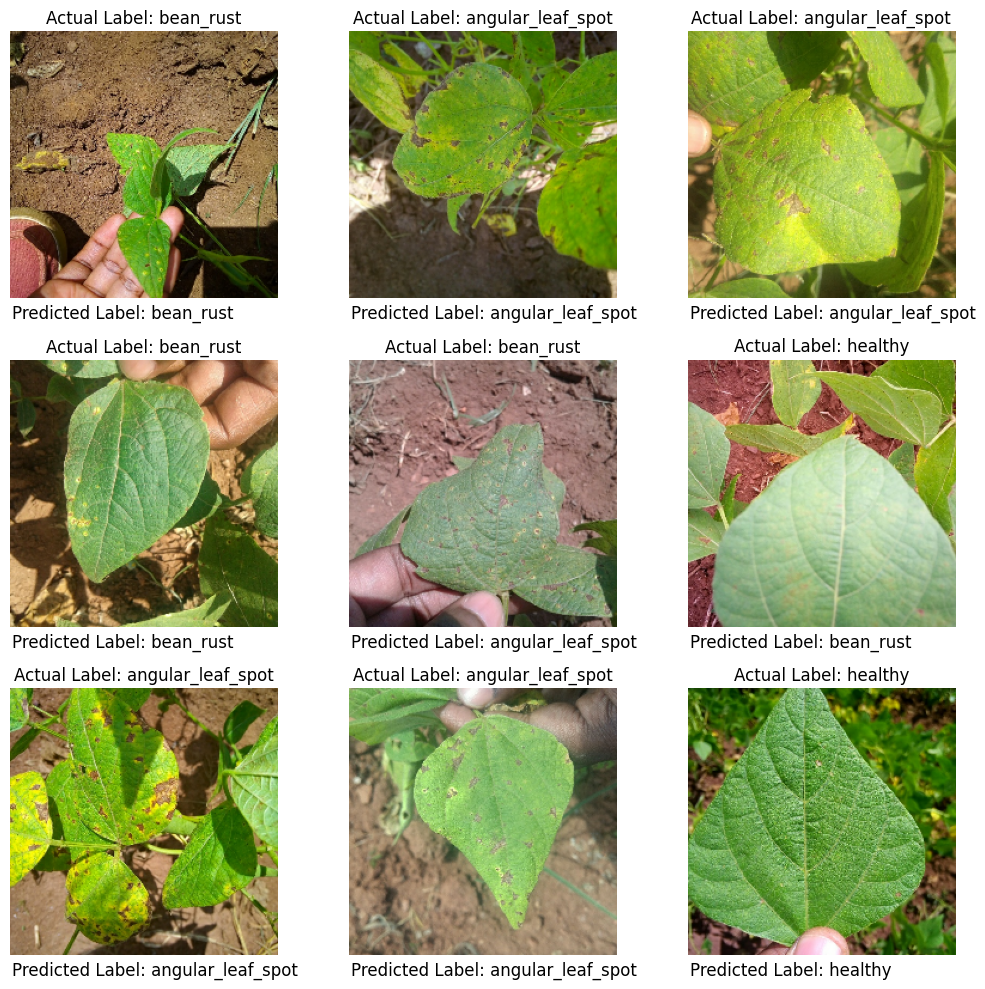

In [34]:
plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)

    plt.tight_layout()

    img = tf.keras.preprocessing.image.img_to_array(images[i])
    img = np.expand_dims(img, axis=0)

    pred=model.predict(img)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title("Actual Label: %s" % classes[labels[i]])
    plt.text(1, 240, "Predicted Label: %s" % classes[np.argmax(pred)], fontsize=12)

    plt.axis("off")

In [36]:
model.export("models")

Saved artifact at 'models'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  136460104865488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136460104638032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136460573927632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136460104762768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136460104773136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136460104645904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136460573931664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136460104638224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136460104635152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136460104775248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136460104767760: TensorS

In [37]:
!ls -alrt models

total 1012
drwxr-xr-x 1 root root    4096 Dec 10 04:50 ..
drwxr-xr-x 2 root root    4096 Dec 10 04:50 variables
drwxr-xr-x 2 root root    4096 Dec 10 04:50 assets
-rw-r--r-- 1 root root 1013840 Dec 10 04:50 saved_model.pb
-rw-r--r-- 1 root root      78 Dec 10 04:50 fingerprint.pb
drwxr-xr-x 4 root root    4096 Dec 10 04:50 .


In [40]:
import tensorflow as tf
from tensorflow import keras
from keras import Input, Model

# load the SavedModel
loaded = tf.saved_model.load("./models")
serving_fn = loaded.signatures["serving_default"]   # inspect loaded.signatures if needed

# wrapper function to call signature
def call_serving(x):
    # convert to tf.Tensor (signature expects certain names/keys; pass positional tensor if supported)
    # signature often expects a tensor named like 'input_1' or similar; try passing positional tensor
    out = serving_fn(tf.cast(x, tf.float32))
    # 'out' is a dict of tensors; pick first key
    return list(out.values())[0]

# build Keras model using Lambda
inputs = Input(shape=(224,224,3), dtype="float32")
x = keras.layers.Lambda(lambda z: call_serving(z))(inputs)
x = keras.layers.Dropout(0.3)(x)
outputs = keras.layers.Dense(3, activation='softmax')(x)
model_loaded = Model(inputs, outputs)


In [38]:
model_loaded = tf.keras.models.load_model('./models/')

ValueError: File format not supported: filepath=./models/. Keras 3 only supports V3 `.keras` files and legacy H5 format files (`.h5` extension). Note that the legacy SavedModel format is not supported by `load_model()` in Keras 3. In order to reload a TensorFlow SavedModel as an inference-only layer in Keras 3, use `keras.layers.TFSMLayer(./models/, call_endpoint='serving_default')` (note that your `call_endpoint` might have a different name).

In [41]:
model_loaded.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            12 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12 (48.00 B)

 Trainable params: 12 (48.00 B)

 Non-trainable params: 0 (0.00 B)

In [42]:
from PIL import Image
import numpy as np
from skimage import transform
def process(filename):
   np_image = Image.open(filename)
   np_image = np.array(np_image).astype('float32')
   np_image = transform.resize(np_image, (224, 224, 3))
   np_image = np.expand_dims(np_image, axis=0)
   return np_image

In [43]:
pred_label=model_loaded.predict(process('beans/train/healthy/healthy_train.0.jpg'))
print(classes[np.argmax(pred_label)])

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
angular_leaf_spot


In [44]:
pred_label

array([[0.40438992, 0.24587458, 0.34973547]], dtype=float32)

In [45]:
!zip -r models.zip models/

  adding: models/ (stored 0%)
  adding: models/saved_model.pb (deflated 91%)
  adding: models/fingerprint.pb (stored 0%)
  adding: models/variables/ (stored 0%)
  adding: models/variables/variables.index (deflated 73%)
  adding: models/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: models/assets/ (stored 0%)


In [46]:
print(tf.__version__)

2.19.0
